In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_pixel_size_path = '/content/drive/My Drive/B3_code/ultrasound_dataset/training_set_pixel_size_and_HC.csv'
test_pixel_size_path = '/content/drive/My Drive/B3_code/ultrasound_dataset/test_set_pixel_size.csv'

train_df = pd.read_csv(train_pixel_size_path)
test_df = pd.read_csv(test_pixel_size_path)

train_df.head()


,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [4]:
images_dir = '/content/drive/My Drive/B3_code/ultrasound_dataset/training_set'
annotations_dir = '/content/drive/My Drive/B3_code/ultrasound_dataset/training_set'


In [5]:
def load_image_and_annotation(image_path, annotation_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0

    annotation = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    annotation = cv2.resize(annotation, (224, 224))

    return image, annotation


In [6]:
def prepare_data(df, images_dir, annotations_dir):
    images = []
    labels = []

    for _, row in df.iterrows():
        image_path = os.path.join(images_dir, row['filename'])
        annotation_path = os.path.join(
            annotations_dir,
            row['filename'].replace('.png', '_Annotation.png')
        )

        image, _ = load_image_and_annotation(image_path, annotation_path)
        images.append(image)
        labels.append(row['head circumference (mm)'])

    return np.array(images), np.array(labels)

X_train, y_train = prepare_data(train_df, images_dir, annotations_dir)
X_train = X_train.reshape(-1, 224, 224, 1)

# y_mean = y_train.mean()
# y_std = y_train.std()

# y_train_norm = (y_train - y_mean) / y_std

In [7]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Normalize
y_mean = y_tr.mean()
y_std = y_tr.std()

y_tr_norm = (y_tr - y_mean) / y_std
y_val_norm = (y_val - y_mean) / y_std


history = model.fit(
    X_tr,
    y_tr_norm,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_norm)
)

val_loss, val_mae_norm = model.evaluate(X_val, y_val_norm)

# milimeters
val_mae_mm = val_mae_norm * y_std
print(f"Validation MAE: {val_mae_mm:.2f} mm")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - loss: 1.4143 - mae: 0.8963 - val_loss: 0.4337 - val_mae: 0.5273
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - loss: 0.5266 - mae: 0.5638 - val_loss: 0.3803 - val_mae: 0.4945
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 0.3659 - mae: 0.4721 - val_loss: 0.3140 - val_mae: 0.4356
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - loss: 0.3040 - mae: 0.4339 - val_loss: 0.2890 - val_mae: 0.4174
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - loss: 0.2151 - mae: 0.3514 - val_loss: 0.3133 - val_mae: 0.4350
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - loss: 0.1727 - mae: 0.3268 - val_loss: 0.2767 - val_mae: 0.4164
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - loss: 0.1238 - mae: 0.2707 - val_loss: 0.2553 - val_mae: 0.3997
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.1001 - mae: 0.2494 - val_loss: 0.2635 - val_mae: 0.3952
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - loss: 0.0647 - m

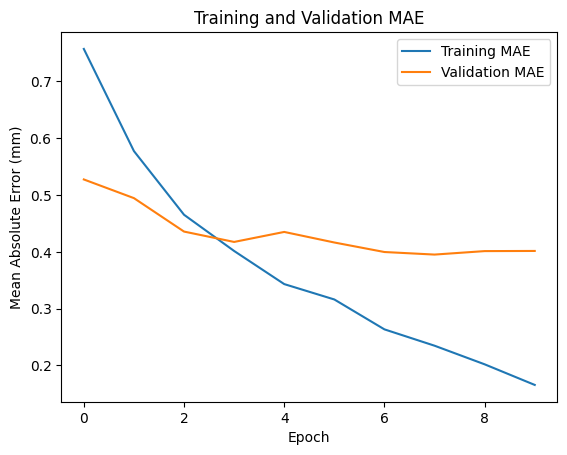

In [9]:

plt.figure()
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (mm)')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

In [10]:
def prepare_test_data(df, images_dir):
    images = []

    for _, row in df.iterrows():
        image_path = os.path.join(images_dir, row['filename'])
        image, _ = load_image_and_annotation(image_path, image_path)
        images.append(image)

    return np.array(images)

X_test = prepare_test_data(
    test_df,
    '/content/drive/My Drive/B3_code/ultrasound_dataset/test_set'
)
X_test = X_test.reshape(-1, 224, 224, 1)

In [11]:
y_pred = model.predict(X_test)

test_df['predicted_head_circumference'] = y_pred
test_df.to_csv(
    '/content/drive/My Drive/B3_code/ultrasound_dataset/test_predictions.csv',
    index=False
)

test_df[['filename', 'predicted_head_circumference']].head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 857ms/step


,filename,predicted_head_circumference
0,000_HC.png,1.452248
1,001_HC.png,-1.356646
2,002_HC.png,-0.072031
3,003_HC.png,0.565906
4,004_HC.png,1.979718
